## Chapter 9 problem: making the model using Flopy
see Anderson, Woessner and Hunt (2015), p 432 for a description

requires the ```flopy``` package (https://github.com/modflowpy/flopy)

<img src="images/prob_descrip.png", align="left">

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import flopy
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Define general model characteristics

In [2]:
path = 'modelfiles' # folder model and PEST files
modelname = 'P9Tcal'
MODFLOW_version='mfnwt'
MODFLOW_exe_name='MODFLOW-NWT.exe', 

#model domain and grid definition
Lx = 1500.
Ly = 1500.
ztop = 600.
zbot = 450.
nlay = 1
nrow = 15
ncol = 15
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# ibound array
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# starting heads
strt = 515. * np.ones((nlay, nrow, ncol), dtype=float)

# properties
Khvalues = {1: 75, 2: 7.5} # dictionary of K values by zone number (1 = sand, 2 = silt)
Vani = 1.
sy = 0.1
ss = 1.e-4
laytyp = 1

# global BC settings
m_riv = 2 # riverbed thickness
w_riv = 100 # riverbed width
R = 0.0001 # recharge rate
Qleak = 45000 # flow through southern boundary (pos. = inflow)
Rcond = 150000

# pumping well for transient simulation
QA = -20000
pumping_well_info = [0, 6, 10, QA] # l, r, c, Q zero-based for flopy!

# Stress Periods
nper = 2
perlen = [1, 3]
nstp = [1, 10]
tsmult = [1, 2]
steady = [True, False]

### Create flopy MODFLOW and package objects

In [3]:
m = flopy.modflow.Modflow(modelname, version=MODFLOW_version, 
                          exe_name=MODFLOW_exe_name, model_ws=path)

#### Discretization

In [4]:
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=botm[1:],
                               nper=nper, perlen=perlen, tsmult=tsmult, nstp=nstp, steady=steady)

#### BAS

In [5]:
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

#### Output control

In [6]:
words = ['save head','save drawdown','save budget']
oc = flopy.modflow.ModflowOc(m, stress_period_data={(0,0): words}, compact=True)

#### Solver

In [7]:
#pcg = flopy.modflow.ModflowPcg(mf, relax=1)
nwt = flopy.modflow.ModflowNwt(m)

In [8]:
# recharge package
rch = flopy.modflow.mfrch.ModflowRch(m, nrchop=3, rech=R, irch=1, extension='rch', unitnumber=19)

#### Make the hydraulic conductivity array (upw package):

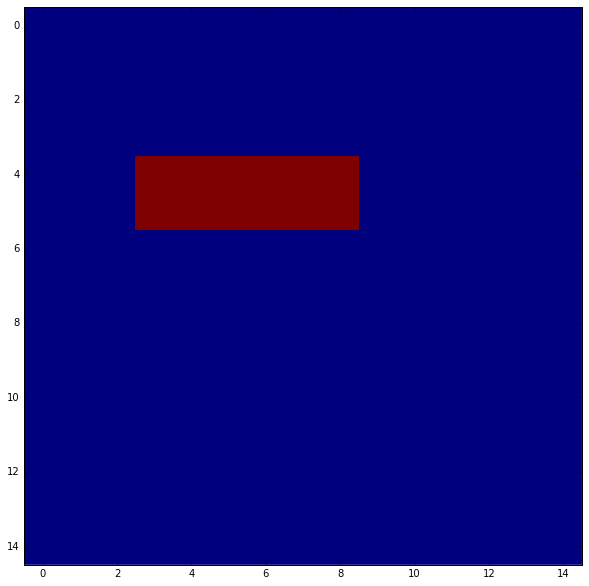

In [9]:
Kzones = np.ones((15, 15))
Kzones[4:6, 3:9] = 2 # rows 5 and 6, columns 4-8 have silt
plt.imshow(Kzones, interpolation='none')

# save the Kzones for calibration with PEST
np.savetxt(os.path.join(path,'Kzones.dat'), Kzones, delimiter=' ', fmt='%i')

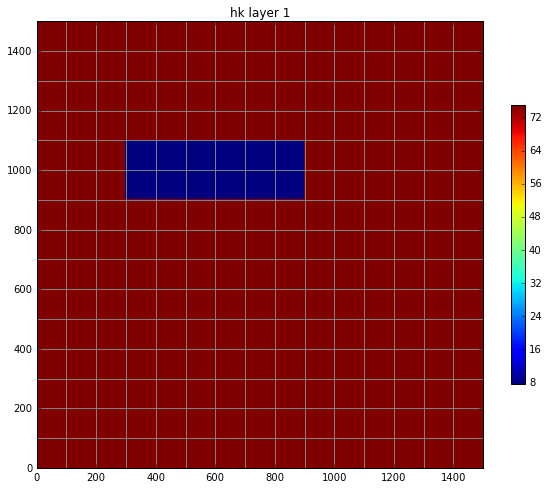

In [10]:
# assign K values based on zone
hk = np.ones((15, 15), dtype=float) # initialize new array for Kvalues
for zone, value in Khvalues.items(): hk[Kzones == zone] = value 

# make the upw object
#lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp)
upw = flopy.modflow.ModflowUpw(m, hk=hk, vka=1, sy=sy, ss=ss, laytyp=laytyp)

# plot the horizontal K array
ax = upw.hk.plot(colorbar=True, grid=True)

#### Now make the river cells:

In [11]:
# bring in river cell information from csv file
rivcells = pd.read_csv('rivercells.csv')

# convert indices to zero-based
rivcells[['layer', 'row', 'column']] = rivcells[['layer', 'row', 'column']] -1

rivcells

,layer,row,column,stage,Rcond,rbot
0,0,0,0,510.0,150000,506.0
1,0,0,1,509.5,150000,505.5
2,0,0,2,509.0,150000,505.0
3,0,0,3,508.5,150000,504.5
4,0,0,4,508.0,150000,504.0
5,0,0,5,507.5,150000,503.5
6,0,0,6,507.0,150000,503.0
7,0,1,7,506.5,150000,502.5
8,0,2,8,506.0,150000,502.0
9,0,2,9,505.5,150000,501.5


In [12]:
# update rCond values with single paramter value from top of script
rivcells['Rcond'] = Rcond

# make dataframe into record array for flopy input
rivdata = rivcells.values

# need to copy river cell info for each stress period
rivdata = {0: rivdata}
rivdata

{0: array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           5.10000000e+02,   1.50000000e+05,   5.06000000e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
           5.09500000e+02,   1.50000000e+05,   5.05500000e+02],
        [  0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
           5.09000000e+02,   1.50000000e+05,   5.05000000e+02],
        [  0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
           5.08500000e+02,   1.50000000e+05,   5.04500000e+02],
        [  0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
           5.08000000e+02,   1.50000000e+05,   5.04000000e+02],
        [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
           5.07500000e+02,   1.50000000e+05,   5.03500000e+02],
        [  0.00000000e+00,   0.00000000e+00,   6.00000000e+00,
           5.07000000e+02,   1.50000000e+05,   5.03000000e+02],
        [  0.00000000e+00,   1.00000000e+00,   7.00000000e+00,
           5.06500000e+02,   1.50000000e+05, 

In [13]:
# make the riv package object
riv = flopy.modflow.mfriv.ModflowRiv(m, ipakcb=53, stress_period_data=rivdata, 
                                     extension='riv', unitnumber=18, options=None, naux=0)

#### Make the leaking ditch:

In [14]:
# designate flux cells
ditch_i = np.ones(15, dtype=int) * 14
ditch_j = np.arange(0, 15)
ditch_i, ditch_j

(array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [15]:
ditch_q = Qleak / len(ditch_i) # flow rate in each constant flux cell

In [16]:
# now make list of layer, row, column, q info for each pumping cell, for each stress period
bflux = {0: [[0, ditch_i[j], j, ditch_q] for j in ditch_j]}

# add pumping well to second (transient) stress period
bflux[1] = pumping_well_info

bflux

{0: [[0, 14, 0, 3000],
  [0, 14, 1, 3000],
  [0, 14, 2, 3000],
  [0, 14, 3, 3000],
  [0, 14, 4, 3000],
  [0, 14, 5, 3000],
  [0, 14, 6, 3000],
  [0, 14, 7, 3000],
  [0, 14, 8, 3000],
  [0, 14, 9, 3000],
  [0, 14, 10, 3000],
  [0, 14, 11, 3000],
  [0, 14, 12, 3000],
  [0, 14, 13, 3000],
  [0, 14, 14, 3000]],
 1: [0, 6, 10, -20000]}

In [17]:
# create the well package
wel = flopy.modflow.ModflowWel(m, stress_period_data=bflux)

#### review the packages that have been created

In [18]:
m.get_package_list()

['DIS', 'BAS6', 'OC', 'NWT', 'RCH', 'UPW', 'RIV', 'WEL']

#### check the model input for common errors

In [19]:
m.check()


P9Tcal MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    RIV package: stage below cell bottom
    RIV package: rbot below cell bottom
    RIV package: RIV stage below rbots
    WEL package: BC indices valid
    WEL package: not a number (Nan) entries
    WEL package: BC in inactive cells
    RCH package: Variable NRCHOP set to 3.
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydraulic conductivity val

<flopy.utils.check.check instance at 0x10da09320>

#### write input

In [20]:
#write the model input files
m.write_input()

#### Visualize model

In [21]:
bflux[0]

[[0, 14, 0, 3000],
 [0, 14, 1, 3000],
 [0, 14, 2, 3000],
 [0, 14, 3, 3000],
 [0, 14, 4, 3000],
 [0, 14, 5, 3000],
 [0, 14, 6, 3000],
 [0, 14, 7, 3000],
 [0, 14, 8, 3000],
 [0, 14, 9, 3000],
 [0, 14, 10, 3000],
 [0, 14, 11, 3000],
 [0, 14, 12, 3000],
 [0, 14, 13, 3000],
 [0, 14, 14, 3000]]

In [22]:
rivcells.row

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     2
9     2
10    2
11    2
12    1
13    1
14    0
Name: row, dtype: int64

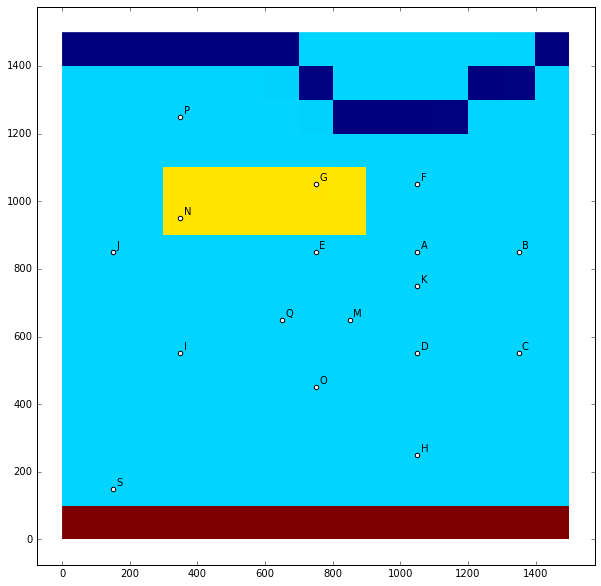

In [23]:
# show the observation locations with the K zones, River cells, and pumping wells
fig, ax = plt.subplots()
extent = [0, 1500, 0, 1500]

# add the river cells and wells to the Kzones array so we can verify where they are
Kzones[rivcells.row, rivcells.column] = 0
Kzones[ditch_i, ditch_j] = 3
    
ax.imshow(Kzones, extent=extent, interpolation='None')
# bring in observation info
obs = pd.read_csv('observations.csv')
ax.scatter(obs.X, obs.Y, c='w')

# label the wells
for i, r in obs.iterrows():
    ax.text(r.X +10, r.Y +10, r.Well)

#### Run the model
can run manually or using flopy if the executable name is supplied as an argument when creating the MODFLOW object  
e.g. 
```
flopy.modflow.Modflow(m, exe_name='MODFLOW-NWT.ext')
```  
and after creating packages
```
m.run_model()
```
see the **Flopy Notebook examples** https://github.com/modflowpy/flopy/tree/master/examples/Notebooks

In [24]:
#m.run_model()

### Finally, make the model creation into a class so we can easily regenerate the model with different parameters
this class is saved in file ```p9model.py```

In [25]:
class problem9model:
    
    MODFLOW_version='mfnwt'
    MODFLOW_exe_name='MODFLOW-NWT.exe', 

    #model domain and grid definition
    Lx = 1500.
    Ly = 1500.
    ztop = 600.
    zbot = 450.
    nlay = 1
    nrow = 15
    ncol = 15
    delr = Lx / ncol
    delc = Ly / nrow
    delv = (ztop - zbot) / nlay
    botm = np.linspace(ztop, zbot, nlay + 1)

    # ibound array
    ibound = np.ones((nlay, nrow, ncol), dtype=int)

    # starting heads
    strt = 515. * np.ones((nlay, nrow, ncol), dtype=float)

    # properties
    Khvalues = {1: 75, 2: 1} # dictionary of K values by zone number (1 = sand, 2 = silt)
    Vani = 1.
    sy = 0.1
    ss = 1.e-4
    laytyp = 1

    # global BC settings
    m_riv = 2 # riverbed thickness
    w_riv = 100 # riverbed width
    R = 0.0001 # recharge rate
    Qleak = 45000 # flow through southern boundary (pos. = inflow)
    Rcond = 150000

    # pumping well for transient simulation
    QA = -20000
    pumping_well_info = [0, 6, 10, QA] # l, r, c, Q zero-based for flopy!

    # Stress Periods
    nper = 2
    perlen = [1, 3]
    nstp = [1, 10]
    tsmult = [1, 2]
    steady = [True, False]
    
    # Kzones
    Kzones = np.ones((15, 15))
    Kzones[4:6, 3:9] = 2 # rows 5 and 6, columns 4-8 have silt
    hk = np.ones((15, 15), dtype=float) # initialize new array for Kvalues
    
    # leaking ditch
    ditch_i = np.ones(15, dtype=int) * 14
    ditch_j = np.arange(0, 15)
    ditch_q = Qleak / len(ditch_i)
    bflux = {0: [[0, ditch_i[j], j, ditch_q] for j in ditch_j]}
    bflux[1] = pumping_well_info
    
    def __init__(self, basename, model_ws):
        self.basename = basename
        self.model_ws = model_ws
        
    def create_input(self):
        m = flopy.modflow.Modflow(self.basename, 
                                       version=self.MODFLOW_version, 
                                       exe_name=self.MODFLOW_exe_name, 
                                       model_ws=self.model_ws)
        dis = flopy.modflow.ModflowDis(m, self.nlay, 
                                       self.nrow, 
                                       self.ncol, 
                                       delr=self.delr, 
                                       delc=self.delc,
                                       top=self.ztop, 
                                       botm=self.botm[1:],
                                       nper=self.nper, 
                                       perlen=self.perlen, 
                                       tsmult=self.tsmult, 
                                       nstp=self.nstp, 
                                       steady=self.steady)
        bas = flopy.modflow.ModflowBas(m, 
                                       ibound=self.ibound, 
                                       strt=self.strt)
        
        words = ['save head','save drawdown','save budget']
        oc = flopy.modflow.ModflowOc(m, stress_period_data={(0,0): words}, compact=True)
        nwt = flopy.modflow.ModflowNwt(m)
        rch = flopy.modflow.mfrch.ModflowRch(m, nrchop=3, rech=self.R, 
                                             irch=1, extension='rch', unitnumber=19)
        
        for zone, value in self.Khvalues.items(): self.hk[self.Kzones == zone] = value
        upw = flopy.modflow.ModflowUpw(m, hk=self.hk, vka=1, 
                                       sy=self.sy, ss=self.ss, laytyp=self.laytyp)

        rivcells = pd.read_csv('rivercells.csv')
        rivcells[['layer', 'row', 'column']] = rivcells[['layer', 'row', 'column']] -1
        rivcells['Rcond'] = self.Rcond
        rivdata = {0: rivcells.values}
        
        riv = flopy.modflow.mfriv.ModflowRiv(m, ipakcb=53, stress_period_data=rivdata, 
                                     extension='riv', unitnumber=18, options=None, naux=0)
        
        wel = flopy.modflow.ModflowWel(m, stress_period_data=self.bflux)
        
        self.m = m
        m.write_input()